In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import json
import numpy as np
import os
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, auc
)
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.nn import CrossEntropyLoss
import nltk
from nltk.data import find
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/cfpb_mortgage_2024_clean.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
# Verify expected columns
print(df.columns)

# Create binary risk flag
RISKY = {"Closed with monetary relief", "Closed with non-monetary relief"}
df["risk_flag"] = df["company_response"].isin(RISKY).astype(int)

# Drop rows with missing or empty narratives
df = df[df["clean_text"].notna() & (df["clean_text"].str.strip() != "")]

# Check class balance
print(df["risk_flag"].value_counts(normalize=True))
print(df["risk_flag"].value_counts())

# First split: train (60%) vs temp (40%)
train_df, temp_df = train_test_split(
    df,
    test_size=0.4,
    stratify=df["risk_flag"],
    random_state=42
)

# Second split: validation (20%) and test (20%) from temp
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["risk_flag"],
    random_state=42
)

# Confirm split sizes and balance
print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train risk ratio:", train_df["risk_flag"].mean())
print("Val risk ratio:", val_df["risk_flag"].mean())
print("Test risk ratio:", test_df["risk_flag"].mean())

# Save splits to data/splits folder
os.makedirs("../data/processed", exist_ok=True)
train_df.to_csv("../data/processed/train.csv", index=False)
val_df.to_csv("../data/processed/val.csv", index=False)
test_df.to_csv("../data/processed/test.csv", index=False)

Index(['complaint_id', 'date_received', 'company', 'issue', 'sub_product',
       'clean_text', 'word_len', 'company_response', 'timely', 'state',
       'month', 'risk_flag'],
      dtype='object')
risk_flag
0    0.951168
1    0.048832
Name: proportion, dtype: float64
risk_flag
0    11239
1      577
Name: count, dtype: int64
Train: 7089 Val: 2363 Test: 2364
Train risk ratio: 0.048808012413598535
Val risk ratio: 0.048666948793906054
Test risk ratio: 0.049069373942470386


In [ ]:
# Load pre-split data
train_df = pd.read_csv("../data/processed/train.csv")
val_df = pd.read_csv("../data/processed/val.csv")
test_df = pd.read_csv("../data/processed/test.csv")

# Extract features and labels
X_train, y_train = train_df["clean_text"], train_df["risk_flag"]
X_val, y_val = val_df["clean_text"], val_df["risk_flag"]
X_test, y_test = test_df["clean_text"], test_df["risk_flag"]

#Rename columns
train_bert = Dataset.from_pandas(train_df[['clean_text', 'risk_flag']].rename(columns={
    'clean_text': 'text',
    'risk_flag': 'label'
}))
val_bert = Dataset.from_pandas(val_df[['clean_text', 'risk_flag']].rename(columns={
    'clean_text': 'text',
    'risk_flag': 'label'
}))
test_bert = Dataset.from_pandas(test_df[['clean_text', 'risk_flag']].rename(columns={
    'clean_text': 'text',
    'risk_flag': 'label'
}))

## BERT

In [ ]:
#Make BERT tokenizer and model
bert_uncased = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_uncased)
bert_classification_model = BertForSequenceClassification.from_pretrained(bert_uncased)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Preprocess input text
max_length = 64

def preprocess_cfpb(data):
    review_text = data['text']

    encoded = bert_tokenizer.batch_encode_plus(
            review_text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
        )

    return encoded

train_bert = train_bert.map(preprocess_cfpb, batched=True)
val_bert   = val_bert.map(preprocess_cfpb, batched=True)
test_bert = test_bert.map(preprocess_cfpb, batched=True)

#Specify training arguments and accuracy
batch_size = 4
num_epochs = 5

bert_args = TrainingArguments(
    output_dir="bert_fine_tuned_cfpb",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    learning_rate=2e-5,
    report_to='none'
)

#Build trainer
bert_trainer = Trainer(
    model=bert_classification_model,
    args=bert_args,
    train_dataset=train_bert,
    eval_dataset=val_bert
)

#Train BERT model
bert_trainer.train()

Map:   0%|          | 0/8127 [00:00<?, ? examples/s]

Map:   0%|          | 0/2363 [00:00<?, ? examples/s]

Map:   0%|          | 0/2364 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.417600,0.296380
2,0.136500,0.421472
3,0.054400,0.568867


Epoch,Training Loss,Validation Loss
1,0.417600,0.296380
2,0.136500,0.421472
3,0.054400,0.568867
4,0.009500,0.605172
5,0.000100,0.596274


TrainOutput(global_step=10160, training_loss=0.13196781726231374, metrics={'train_runtime': 573.4329, 'train_samples_per_second': 70.863, 'train_steps_per_second': 17.718, 'total_flos': 1336439716819200.0, 'train_loss': 0.13196781726231374, 'epoch': 5.0})

In [ ]:
test_preds = bert_trainer.predict(test_bert)

              precision    recall  f1-score   support

           0      0.958     0.976     0.967      2248
           1      0.267     0.172     0.209       116

    accuracy                          0.936      2364
   macro avg      0.612     0.574     0.588      2364
weighted avg      0.924     0.936     0.930      2364

ROC-AUC: 0.6867867222972144


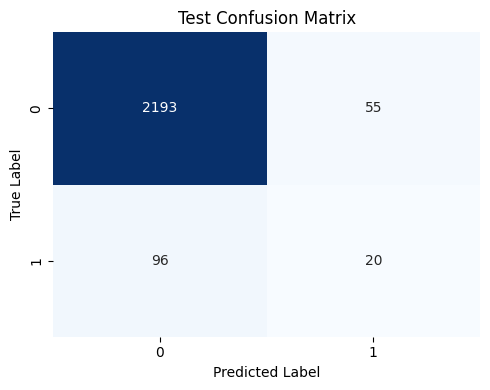

In [ ]:
#Calculate test metrics
logits_test = test_preds.predictions
y_test_true = test_preds.label_ids
y_test_pred = np.argmax(logits_test, axis=1)
y_test_prob = torch.softmax(torch.tensor(logits_test), dim=1)[:, 1].numpy()
print(classification_report(y_test_true, y_test_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test_true, y_test_prob))

# Confusion matrix
cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

##RoBERTa

In [ ]:
#Make RoBERTa tokenizer and model
roberta = 'roberta-base'
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta)
roberta_classification_model = AutoModelForSequenceClassification.from_pretrained(roberta, num_labels = 2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Preprocess input text
max_length = 64

def preprocess_cfpb2(data):
    review_text = data['text']

    encoded = roberta_tokenizer(
            review_text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
        )

    return encoded

train_roberta = train_bert.map(preprocess_cfpb2, batched=True)
val_roberta   = val_bert.map(preprocess_cfpb2, batched=True)
test_roberta = test_bert.map(preprocess_cfpb2, batched=True)

#Specify training arguments and accuracy
batch_size = 4
num_epochs = 5

roberta_args = TrainingArguments(
    output_dir="roberta_fine_tuned_cfpb",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    learning_rate=2e-5,
    report_to='none'
)

#Build trainer
roberta_trainer = Trainer(
    model=roberta_classification_model,
    args=roberta_args,
    train_dataset=train_roberta,
    eval_dataset=val_roberta
)

#Train RoBERTa model
roberta_trainer.train()

Map:   0%|          | 0/8127 [00:00<?, ? examples/s]

Map:   0%|          | 0/2363 [00:00<?, ? examples/s]

Map:   0%|          | 0/2364 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.497200,0.199474
2,0.524900,0.214738
3,0.494100,0.224132
4,0.501400,0.194577
5,0.521200,0.337141


TrainOutput(global_step=10160, training_loss=0.5147120798666646, metrics={'train_runtime': 634.4587, 'train_samples_per_second': 64.047, 'train_steps_per_second': 16.014, 'total_flos': 1336439716819200.0, 'train_loss': 0.5147120798666646, 'epoch': 5.0})

In [ ]:
test_preds2 = roberta_trainer.predict(test_roberta)

              precision    recall  f1-score   support

           0      0.963     0.918     0.940      2248
           1      0.163     0.310     0.214       116

    accuracy                          0.888      2364
   macro avg      0.563     0.614     0.577      2364
weighted avg      0.923     0.888     0.904      2364

ROC-AUC: 0.6942646336973861


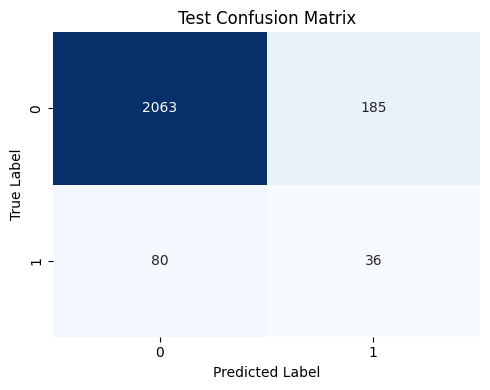

In [ ]:
#Calculate test metrics
logits_test = test_preds2.predictions
y_test_true = test_preds2.label_ids
y_test_pred = np.argmax(logits_test, axis=1)
y_test_prob = torch.softmax(torch.tensor(logits_test), dim=1)[:, 1].numpy()
print(classification_report(y_test_true, y_test_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test_true, y_test_prob))

# Confusion matrix
cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

##ModernBERT

In [ ]:
#Make ModernBERT tokenizer and model
modern_bert = "answerdotai/ModernBERT-base"
modern_tokenizer = AutoTokenizer.from_pretrained(modern_bert)
modern_model = AutoModelForSequenceClassification.from_pretrained(modern_bert, num_labels=2)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Preprocess input text
max_length = 64

def preprocess_modern(data):
    review_text = data['text']

    encoded = modern_tokenizer(
            review_text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
        )

    return encoded

train_modern = train_bert.map(preprocess_modern, batched=True)
val_modern   = val_bert.map(preprocess_modern, batched=True)
test_modern = test_bert.map(preprocess_modern, batched=True)

#Specify training arguments and accuracy
batch_size = 4
num_epochs = 5

modern_args = TrainingArguments(
    output_dir="modern_fine_tuned_cfpb",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    learning_rate=2e-5,
    report_to='none'
)

#Build trainer
modern_trainer = Trainer(
    model=modern_model,
    args=modern_args,
    train_dataset=train_modern,
    eval_dataset=val_modern
)

#Train ModernBERT model
modern_trainer.train()

Map:   0%|          | 0/8127 [00:00<?, ? examples/s]

Map:   0%|          | 0/2363 [00:00<?, ? examples/s]

Map:   0%|          | 0/2364 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.251900,0.452439


Epoch,Training Loss,Validation Loss
1,0.251900,0.452439
2,0.023800,0.821586
3,0.013000,0.794163
4,0.006000,0.817022
5,0.000100,0.797470


TrainOutput(global_step=10160, training_loss=0.0926018711460099, metrics={'train_runtime': 1099.1722, 'train_samples_per_second': 36.969, 'train_steps_per_second': 9.243, 'total_flos': 1730836884107520.0, 'train_loss': 0.0926018711460099, 'epoch': 5.0})

In [ ]:
test_preds3 = modern_trainer.predict(test_modern)

              precision    recall  f1-score   support

           0      0.953     0.996     0.974      2248
           1      0.333     0.043     0.076       116

    accuracy                          0.949      2364
   macro avg      0.643     0.519     0.525      2364
weighted avg      0.922     0.949     0.930      2364

ROC-AUC: 0.6465862375751626


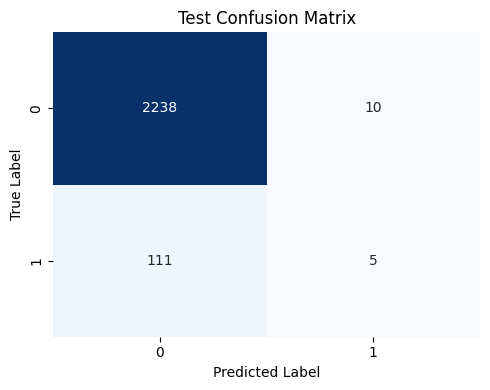

In [ ]:
#Calculate test metrics
logits_test = test_preds3.predictions
y_test_true = test_preds3.label_ids
y_test_pred = np.argmax(logits_test, axis=1)
y_test_prob = torch.softmax(torch.tensor(logits_test), dim=1)[:, 1].numpy()
print(classification_report(y_test_true, y_test_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test_true, y_test_prob))

# Confusion matrix
cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

##Fine-tuned RoBERTa

In [ ]:
#Make RoBERTa tokenizer and model
roberta = 'roberta-base'
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta)
roberta_classification_model = AutoModelForSequenceClassification.from_pretrained(roberta, num_labels = 2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Preprocess input text
max_length = 64

def preprocess_cfpb2(data):
    review_text = data['text']

    encoded = roberta_tokenizer(
            review_text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
        )

    return encoded

train_roberta = train_bert.map(preprocess_cfpb2, batched=True)
val_roberta   = val_bert.map(preprocess_cfpb2, batched=True)
test_roberta = test_bert.map(preprocess_cfpb2, batched=True)

#Specify training arguments and accuracy
#Add weight decay and change learning rate
batch_size = 4
num_epochs = 5

roberta_args = TrainingArguments(
    output_dir="roberta_fine_tuned_cfpb",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=.01,
    eval_strategy="epoch",
    learning_rate=1e-5,
    report_to='none'
)

#Build trainer
roberta_trainer = Trainer(
    model=roberta_classification_model,
    args=roberta_args,
    train_dataset=train_roberta,
    eval_dataset=val_roberta
)

#Train RoBERTa model
roberta_trainer.train()

Map:   0%|          | 0/8127 [00:00<?, ? examples/s]

Map:   0%|          | 0/2363 [00:00<?, ? examples/s]

Map:   0%|          | 0/2364 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.516900,0.245546
2,0.415000,0.397855
3,0.265500,0.459889
4,0.150200,0.581263
5,0.080200,0.556852


TrainOutput(global_step=10160, training_loss=0.3007794481562817, metrics={'train_runtime': 625.1297, 'train_samples_per_second': 65.003, 'train_steps_per_second': 16.253, 'total_flos': 1336439716819200.0, 'train_loss': 0.3007794481562817, 'epoch': 5.0})

In [ ]:
test_preds3 = roberta_trainer.predict(test_roberta)

              precision    recall  f1-score   support

           0      0.965     0.919     0.942      2248
           1      0.188     0.362     0.247       116

    accuracy                          0.892      2364
   macro avg      0.576     0.641     0.594      2364
weighted avg      0.927     0.892     0.908      2364

ROC-AUC: 0.7251982605227636


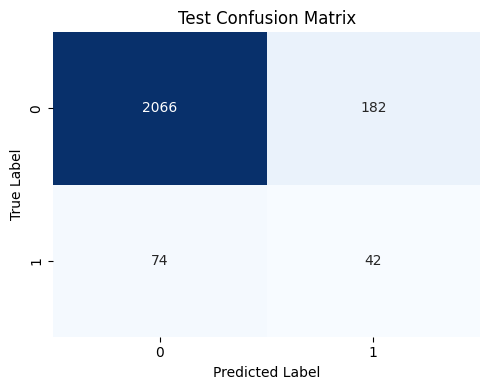

In [ ]:
#Calculate test metrics
logits_test = test_preds3.predictions
y_test_true = test_preds3.label_ids
y_test_prob = torch.softmax(torch.tensor(logits_test), dim=1)[:, 1].numpy()
#Adjust classification threshold
threshold = .4
y_test_pred = (y_test_prob >= threshold).astype(int)
print(classification_report(y_test_true, y_test_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test_true, y_test_prob))

# Confusion matrix
cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

##Final RoBERTa Model

In [ ]:
#Make RoBERTa tokenizer and model
roberta = 'roberta-base'
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta)
roberta_classification_model = AutoModelForSequenceClassification.from_pretrained(roberta, num_labels = 2)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compute class weights from train_df
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

counts = train_df["risk_flag"].value_counts()
n_neg = counts[0]
n_pos = counts[1]

weight_for_0 = 1.0
weight_for_1 = (n_neg / n_pos) * 2

class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float, device=device)
print("Class Weights:", class_weights)

# Define a weighted Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Remove labels from dictionary to allow computatio of loss manually
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Apply custom weighted loss
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1)
        )
        return (loss, outputs) if return_outputs else loss

Class Weights: tensor([ 1.0000, 38.9769], device='cuda:0')


In [ ]:
#Preprocess input text and increase max length
max_length = 112

def preprocess_cfpb2(data):
    review_text = data['text']

    encoded = roberta_tokenizer(
            review_text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
        )

    return encoded

train_roberta = train_bert.map(preprocess_cfpb2, batched=True)
val_roberta   = val_bert.map(preprocess_cfpb2, batched=True)
test_roberta = test_bert.map(preprocess_cfpb2, batched=True)

#Specify training arguments and accuracy
#Add weight decay and change learning rate
batch_size = 4
num_epochs = 5

roberta_args = TrainingArguments(
    output_dir="roberta_fine_tuned_cfpb",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=.01,
    eval_strategy="epoch",
    learning_rate=1e-5,
    report_to='none'
)

#Build trainer
roberta_trainer = WeightedTrainer(
    model=roberta_classification_model,
    args=roberta_args,
    train_dataset=train_roberta,
    eval_dataset=val_roberta,
    tokenizer=roberta_tokenizer
)

#Train RoBERTa model
roberta_trainer.train()

Map:   0%|          | 0/7089 [00:00<?, ? examples/s]

Map:   0%|          | 0/2363 [00:00<?, ? examples/s]

Map:   0%|          | 0/2364 [00:00<?, ? examples/s]

/tmp/ipython-input-2561595491.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  roberta_trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss
1,0.900000,0.855901
2,0.909500,0.839738
3,0.684400,0.821935
4,0.672000,0.914078
5,0.540900,0.932628


TrainOutput(global_step=8865, training_loss=0.7310344767046055, metrics={'train_runtime': 632.5042, 'train_samples_per_second': 56.039, 'train_steps_per_second': 14.016, 'total_flos': 2040056234395200.0, 'train_loss': 0.7310344767046055, 'epoch': 5.0})

In [ ]:
test_preds4 = roberta_trainer.predict(test_roberta)

              precision    recall  f1-score   support

           0      0.959     0.976     0.967      2248
           1      0.295     0.198     0.237       116

    accuracy                          0.937      2364
   macro avg      0.627     0.587     0.602      2364
weighted avg      0.927     0.937     0.932      2364

ROC-AUC: 0.7623193796784881


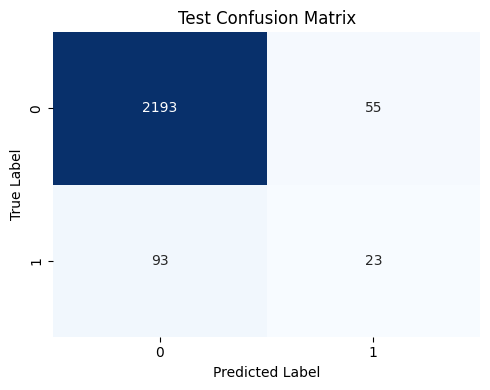

In [ ]:
#Calculate test metrics
logits_test = test_preds4.predictions
y_test_true = test_preds4.label_ids
y_test_prob = torch.softmax(torch.tensor(logits_test), dim=1)[:, 1].numpy()
#Adjust classification threshold
threshold = .4
y_test_pred = (y_test_prob >= threshold).astype(int)
clf_report = classification_report(y_test_true, y_test_pred, output_dict=True)
print(classification_report(y_test_true, y_test_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test_true, y_test_prob))

# Confusion matrix
cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
#Save results for later
roberta_results = {
    "model_name": "roberta_weighted_finetuned",
    "performance": {
        "test": {
            "roc_auc": float(roc_auc_score(y_test_true, y_test_prob)),
            "precision_risk": float(np.round(clf_report['1']['precision'], 3)),
            "recall_risk": float(np.round(clf_report['1']['recall'], 3)),
            "f1_risk": float(np.round(clf_report['1']['f1-score'], 3)),
            "accuracy": float(np.round(clf_report['accuracy'], 3))
        }
    }
}

# Create output folder
os.makedirs("../outputs/models", exist_ok=True)

# Save as JSON
output_path = "../outputs/models/roberta_weighted_results.json"

with open(output_path, "w") as f:
    json.dump(roberta_results, f, indent=4)

print("Saved results to:", output_path)

Saved results to: ../outputs/models/roberta_weighted_results.json
